# AI_18_박경훈 Section2 Projcet

# 0. 문제 정의 및 데이터 선정 이유
---
## 문제정의
* 영국의 금융회사에서 근무중.
* 고객의 정보로부터 채무불이행 여부를 예측하여 손실을 최소화하고자함. 즉 분류문제이다.  
    - 따라서 비교적 구하기쉽거나 여러 데이터셋에 자주 포함되어있는 특성들로  
머신러닝 모델을 구성해야함.

## 데이터 선정 이유
* 선정한 데이터는 NBFI Vehicle Loan repayment Dataset 으로,  
ID를 제외한 38개의 feature와 default 여부로 이루어진 CC0 라이선스 데이터셋이다.  
(링크 : https://www.kaggle.com/datasets/meastanmay/nbfi-vehicle-loan-repayment-dataset)

* 해당 데이터셋은 비은행금융회사 및 기관들의 고객정보와 자동차대출의 채무불이행 여부를  
확인할 수 있는 데이터셋이며, 약 12만개로 학습에 충분한 관측치와 다수의 feature들을  
포함하고있다. 또한 CC0 라이선스로 저작권문제에서 자유롭기때문에 채택하였다.

* 데이터셋이 자동차대출에 한정되어있으므로 모든 대출에 대해 일반화는 불가능하지만,  
보통 어느한건이라도 채무불이행 이력이 있는 사람은 타 대출과도 강한 상관관계가 있는것이  
일반적인 상식이므로 판단의 보조수단중 하나로서 기능할 수 있다고 판단하였다.  

## 가설설정
* EDA를 통해 확인 가능한 가설과, Model의 예측값을 통해 확인가능한 가설을 설정

* EDA를 통해 확인 가능한 가설
1. 계약요일 및 시간과 채무불이행율은 관계가 있을것이다.
2. 가족 구성원이 많아질수록 채무불이행율은 낮아질 것이다.

* Model의 예측값을 통해 확인 가능한 가설
1. 연령은 예측에 중요한 영향을 미치는 요소일 것이다. (PI)  
2. Client_Income이 오르면 채무불이행율 예측값은 감소할것이다. (PDP)


# 1. EDA & 전처리
---
* 해당데이터셋은 현재 근무를 가정하고있는 회사의 데이터셋이 아니고, 문제도 자동차대출로  
한정되어있지 않다. 따라서 구하기 쉽고 일반적이라 판단되는 feature들을 선택하여 모델학습 진행예정  
 => 즉, 1차 feature selection은 머신러닝 외적인 이유로 진행

* 1차 feature selection이후 자료형변환 -> 중복치처리 -> 시각화 -> 가설검정 -> 결측치처리  
순서로 진행

## 1차 feature selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import *

from category_encoders import OrdinalEncoder, TargetEncoder

from xgboost import XGBClassifier

In [2]:
df_dict =pd.read_csv('vehicle_loan_dictionary.csv')
df = pd.read_csv('vehicle_loan_train.csv', low_memory=False)
df.info()
display(df.head(5))
target = 'Default'
# 약 12만명의 고객 데이터, ID, target을 제외한 38개 feature

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121856 entries, 0 to 121855
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ID                          121856 non-null  int64  
 1   Client_Income               118249 non-null  object 
 2   Car_Owned                   118275 non-null  float64
 3   Bike_Owned                  118232 non-null  float64
 4   Active_Loan                 118221 non-null  float64
 5   House_Own                   118195 non-null  float64
 6   Child_Count                 118218 non-null  float64
 7   Credit_Amount               118224 non-null  object 
 8   Loan_Annuity                117044 non-null  object 
 9   Accompany_Client            120110 non-null  object 
 10  Client_Income_Type          118155 non-null  object 
 11  Client_Education            118211 non-null  object 
 12  Client_Marital_Status       118383 non-null  object 
 13  Client_Gender 

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,...,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
0,12142509,6750,0.0,0.0,1.0,0.0,0.0,61190.55,3416.85,Alone,...,Yes,Yes,Self-employed,0.568066,0.478787,NaN,0.0186,63.0,NaN,0
1,12138936,20250,1.0,0.0,1.0,NaN,0.0,15282,1826.55,Alone,...,Yes,Yes,Government,0.563360,0.215068,NaN,NaN,NaN,NaN,0
2,12181264,18000,0.0,0.0,1.0,0.0,1.0,59527.35,2788.2,Alone,...,Yes,Yes,Self-employed,NaN,0.552795,0.329655054,0.0742,277.0,0.0,0
3,12188929,15750,0.0,0.0,1.0,1.0,0.0,53870.4,2295.45,Alone,...,Yes,Yes,XNA,NaN,0.135182,0.631354537,NaN,1700.0,3.0,0
4,12133385,33750,1.0,0.0,1.0,0.0,2.0,133988.4,3547.35,Alone,...,Yes,Yes,Business Entity Type 3,0.508199,0.301182,0.355638717,0.2021,674.0,1.0,0


In [3]:
pd.options.display.max_colwidth = 300
display(df_dict)
# 기준1 : 자동차대출에 한정되어있지않은 일반적인 feature들을 선택
# 기준2 : 대출이전에 얻을 수 있는 feature들을 선택
# ==========================================================
# ID : Primary Key 이므로 선택
# Client_Income - Loan_Annuity : 흔히 얻을 수 있는 정보이므로 선택
# Client_Income_Type - Client_Gender : 마찬가지로 흔한 개인정보 이므로 선택
# Loan_Contract_Type : 현금인지 리볼빙인지에 대한 중요정보. 선택
# Client_Housing_Type : 주거 형태에 대한 정보이므로 선택
# Age_Days - Registration_Days : 흔히얻는 기본정보이므로 선택
# Client_Occupation - Client_Family_Members : 직업, 가족수이므로 선택
# Application_Process_Day - Hour : 가입요일, 일시이므로 선택
# Type_Organization : 직장 구분이므로 선택

def prepro1(data, data_dict, is_test=False):
    if is_test == True:
        cols = data_dict.iloc[np.r_[0:9, 10:16, 17:20, 25:27, 28:30, 32]].Variable.values
    else:
        cols = data_dict.iloc[np.r_[0:9, 10:16, 17:20, 25:27, 28:30, 32, 39]].Variable.values
    df = data[cols]
    return df

,Variable,Description
0,ID,Client Loan application ID
1,Client_Income,Client Income in $
2,Car_Owned,Any Car owned by client before applying for the loan for another car (0 means No and 1 means otherwise)
3,Bike_Owned,Any bike owned by client (0 means No and 1 means otherwise)
4,Active_Loan,Any other active loan at the time of aplication of loan (0 means No and 1 means otherwise)
5,House_Own,Any house owned by client (0 means No and 1 means otherwise)
6,Child_Count,Number of children the client has
7,Credit_Amount,Credit amount of the loan in $
8,Loan_Annuity,Loan annuity in $
9,Accompany_Client,Who accompanied the client when client applied for the loan


In [4]:
df2 = prepro1(df, df_dict)

df2.info()
# 2개의 기준을 통해 38개 feature중에 22개를 선택하였다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121856 entries, 0 to 121855
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        121856 non-null  int64  
 1   Client_Income             118249 non-null  object 
 2   Car_Owned                 118275 non-null  float64
 3   Bike_Owned                118232 non-null  float64
 4   Active_Loan               118221 non-null  float64
 5   House_Own                 118195 non-null  float64
 6   Child_Count               118218 non-null  float64
 7   Credit_Amount             118224 non-null  object 
 8   Loan_Annuity              117044 non-null  object 
 9   Client_Income_Type        118155 non-null  object 
 10  Client_Education          118211 non-null  object 
 11  Client_Marital_Status     118383 non-null  object 
 12  Client_Gender             119443 non-null  object 
 13  Loan_Contract_Type        118205 non-null  o

## 자료형 변환

In [5]:
# 수치형 feature : Client_Income, Credit_Amount, Loan_Annuity,
#                 Age_Days, Employed_Days, Registration_Days,
# 범주형 feature : 그외 전부
# => 수치형 6개(ID제외) 범주형 16개
num_cols = ['ID', 'Client_Income', 'Credit_Amount', 'Loan_Annuity',\
            'Age_Days', 'Employed_Days', 'Registration_Days']
cat_cols = list(df2.loc[[0], ~df2.columns.isin(num_cols)].columns)

# 수치형 컬럼들이 숫자와 소수점 이외의 값을 같는지 확인
print('\nNum_cols strange values')
for i in num_cols:
    if df2[i].dtype == 'object':
        print(i,': ',df2[df2[i].str.contains(r'[^0-9.]', na=False)][i].unique())
# $, #VAlUE!, x 존재.

# 범주형 컬럼 유니크값 및 카디널리티 확인
print('\nUnique Values')
for i in cat_cols:
    print(i,': ',df2[i].unique())
    
print('\nUnique Values count')
df2[cat_cols].nunique().sort_values(ascending=False)
# Type_Organization이 카디널리티가 높다.


Num_cols strange values
Client_Income :  ['$']
Credit_Amount :  ['$']
Loan_Annuity :  ['$' '#VALUE!']
Age_Days :  ['x']
Employed_Days :  ['x']
Registration_Days :  ['x']

Unique Values
Car_Owned :  [ 0.  1. nan]
Bike_Owned :  [ 0.  1. nan]
Active_Loan :  [ 1.  0. nan]
House_Own :  [ 0. nan  1.]
Child_Count :  [ 0.  1.  2. nan  3.  4.  5.  7.  8. 10.  6. 19. 12. 14.  9.]
Client_Income_Type :  ['Commercial' 'Service' 'Retired' 'Govt Job' nan 'Student' 'Unemployed'
 'Maternity leave' 'Businessman']
Client_Education :  ['Secondary' 'Graduation' 'Graduation dropout' nan 'Junior secondary'
 'Post Grad']
Client_Marital_Status :  ['M' 'W' 'S' nan 'D']
Client_Gender :  ['Male' 'Female' nan 'XNA']
Loan_Contract_Type :  ['CL' 'RL' nan]
Client_Housing_Type :  ['Home' 'Family' 'Office' 'Municipal' nan 'Rental' 'Shared']
Client_Occupation :  ['Sales' nan 'Realty agents' 'Laborers' 'Core' 'Drivers' 'Managers'
 'Accountants' 'High skill tech' 'Cleaning' 'HR' 'Waiters/barmen'
 'Low-skill Laborers' 'Me

Type_Organization           58
Application_Process_Hour    24
Client_Occupation           18
Client_Family_Members       15
Child_Count                 14
Client_Income_Type           8
Application_Process_Day      7
Client_Housing_Type          6
Client_Education             5
Client_Marital_Status        4
Client_Gender                3
Car_Owned                    2
Loan_Contract_Type           2
Bike_Owned                   2
House_Own                    2
Active_Loan                  2
Default                      2
dtype: int64

In [6]:
def prepro2(data, is_test=False):
    data = data.copy()
    data[num_cols] = data[num_cols].replace(r'[$x\s]|(#VALUE!)', value='', regex=True)
    data[num_cols] = data[num_cols].replace('', np.nan)
    data[num_cols] = data[num_cols].astype('float')
    data.ID = data.ID.astype('int')
    if is_test == True:
        tcols = cat_cols.copy()
        tcols.remove(target)
        data[tcols] = data[tcols].astype('category')
    else:
        data[cat_cols] = data[cat_cols].astype('category')
    return data

df3 = prepro2(df2)
df3.info()

print(f"\n중복행 갯수 : {df3.duplicated(subset='ID').sum()}")
#중복치 없음

# 자료형 전부 변환완료.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121856 entries, 0 to 121855
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   ID                        121856 non-null  int32   
 1   Client_Income             118234 non-null  float64 
 2   Car_Owned                 118275 non-null  category
 3   Bike_Owned                118232 non-null  category
 4   Active_Loan               118221 non-null  category
 5   House_Own                 118195 non-null  category
 6   Child_Count               118218 non-null  category
 7   Credit_Amount             118219 non-null  float64 
 8   Loan_Annuity              117030 non-null  float64 
 9   Client_Income_Type        118155 non-null  category
 10  Client_Education          118211 non-null  category
 11  Client_Marital_Status     118383 non-null  category
 12  Client_Gender             119443 non-null  category
 13  Loan_Contract_Type        118

Feature 설명  
`ID` : 고객 고유값  
`Client_Income` : 고객 수입 ($)  
`Car_Owned` : 차량소유여부 (0:없음, 1:있음)  
`Bike_Owned` : 오토바이소유여부 (0:없음, 1:있음)  
`Active_Loan` : 다른 대출이 존재하는지 여부 (0:없음, 1:있음)  
`House_Own` : 자가 존재여부 (0:없음, 1:있음)  
`Child_Count` : 자녀의 숫자  
`Credit_Amount` : 대출액  
`Loan_Annuity` : 단위기간당 상환액  
`Client_Income_Type` : 고객의 소득 분류(자영업, 학생, 은퇴 등..)  
`Client_Marital_Status` : 기혼여부 (D:이혼, S:미혼, M:기혼, W:미망인)  
`Client_Gender` : 고객 성별  
`Loan_Contract_Type` : 대출 종류 (CL:현금, RL:리볼빙)  
`Client_Housing_Type` : 주거형태  
`Age_Days` : 고객연령 (일수로 계산)  
`Employed_Days` : 계약일 기준 고용된 일 수  
`Registration_Days` : 계약일 기준 자동차등록 일 수  
`Client_Occupation` : 고객 직업  
`Client_Family_Members` : 가족의 수  
`Application_Process_Day` : 계약이 발생한 요일  
`Application_Process_Hour` : 계약이 발생한 시간  
`Type_Organization` : 직종분류  
`Default (target)` : 채무불이행여부 (0:정상, 1:불이행)

In [7]:
feature_dict = {'Application_Process_Day':{0:'Sun', 1:'Mon', 2:'Tues', 3:'Wends', 4:'Thurs', 5:'Fri', 6:'Sat'},
               'Client_Marital_Status':{'D':'Divorced', 'S':'Single', 'M':'Married', 'W':'Widowed'}}

## 시각화 및 이상치처리
* 수치형 변수들 시각화 및 이상치 처리
* 관심있는 몇몇 변수형 범주들 시각화

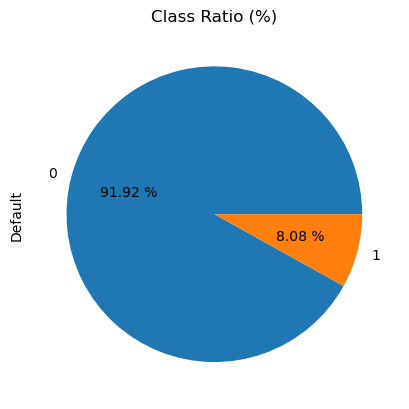

In [8]:
# Target variable 비율
df3[target].value_counts(normalize=True).plot.pie(autopct='%.2f %%')
plt.title('Class Ratio (%)')
plt.show()
# 1의 비율 약 8%로, 클래스 불균형이 심하다.

,count,mean,std,min,25%,50%,75%,max
Client_Income,118234.0,16865.191737,11538.154494,2565.0,11250.0,14400.0,20250.0,1800009.0


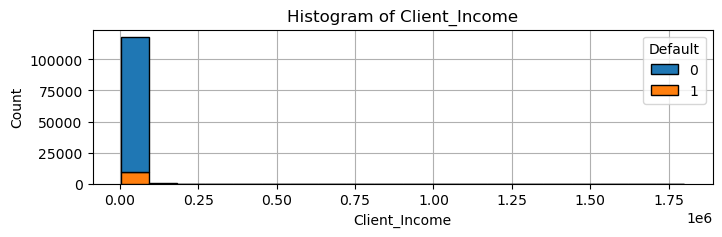

,count,mean,std,min,25%,50%,75%,max
Credit_Amount,118219.0,60046.488951,40350.663346,4500.0,27000.0,51750.0,80865.0,405000.0


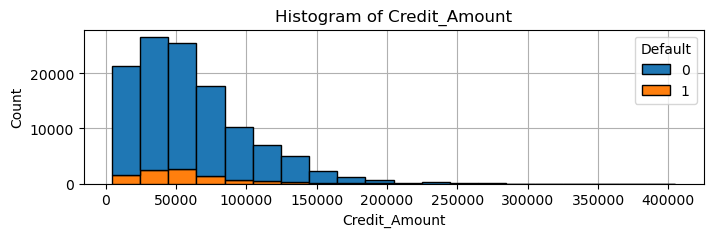

,count,mean,std,min,25%,50%,75%,max
Loan_Annuity,117030.0,2721.254492,1461.466162,217.35,1657.35,2499.75,3466.8,22500.0


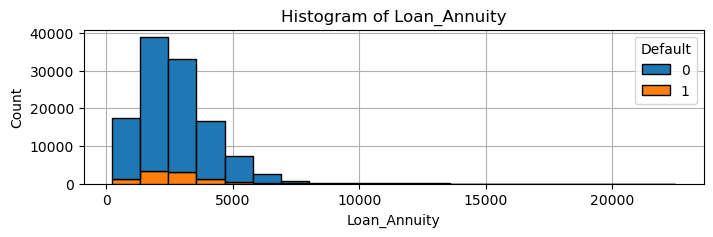

,count,mean,std,min,25%,50%,75%,max
Age_Days,118239.0,16027.422948,4366.356504,7676.0,12398.0,15734.0,19661.0,25201.0


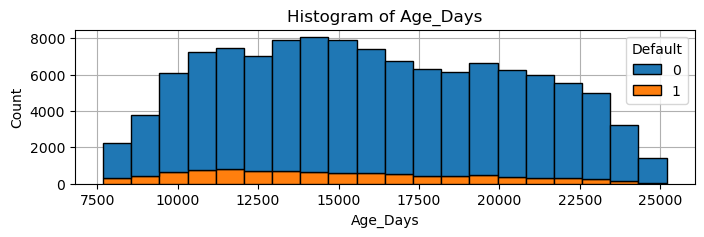

,count,mean,std,min,25%,50%,75%,max
Employed_Days,118190.0,67154.070615,138971.782951,0.0,932.0,2212.0,5634.0,365243.0


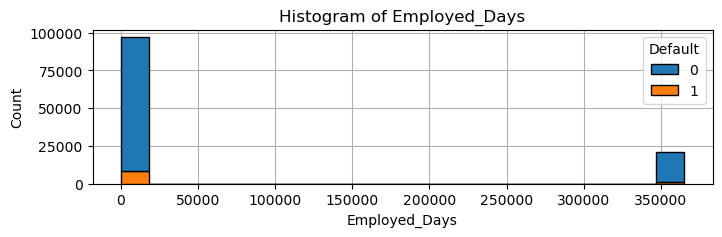

,count,mean,std,min,25%,50%,75%,max
Registration_Days,118225.0,4975.162123,3514.546963,0.0,2008.0,4493.0,7464.0,23738.0


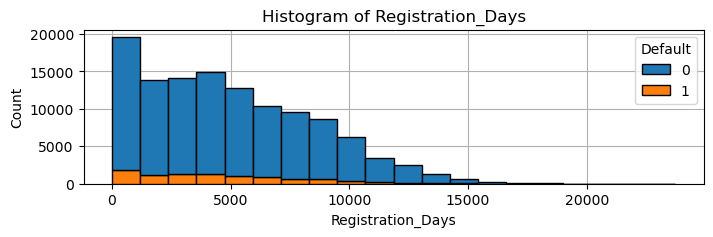

In [9]:
# 수치형 변수 시각화
def vis_num(data, col, bins=100, trimIQR=None, describe=True):
    if describe == True:
        display(data[[col]].describe().T)
    if trimIQR != None:
        Q3 = data[col].quantile(.75)
        Q1 = data[col].quantile(.25)
        trim = trimIQR*(Q3-Q1)
        data2 = data[(data[col] >= Q1-trim) & (data[col] <= Q3+trim)] 
    else:
        data2 = data
    plt.figure(figsize=(8,2))
    sns.histplot(data=data2, x=col, bins=bins, hue='Default',
                legend=True, multiple='stack', alpha=1,
                zorder=3)
    plt.grid(zorder=0)
    plt.title(f'Histogram of {col}')
    plt.show()


for i in num_cols:
    if i != 'ID':
        vis_num(df3, i, bins=20, trimIQR=None,
                describe=True)

# Client_Income에 매우큰 이상치 존재하나, 오기입은 아님.
# Employed_Days에 이상치 존재하며, 비상식적인 수치이므로 오기입이다.
# 눈으로보기에 채무불이행 여부에따른 차이는 확인되지 않는다.

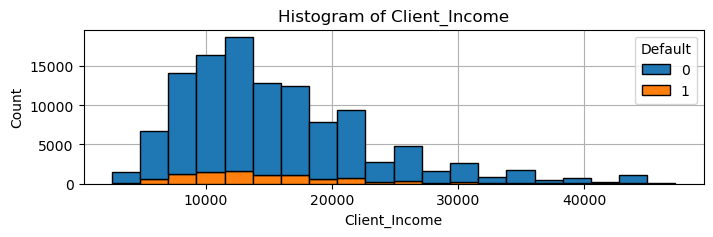

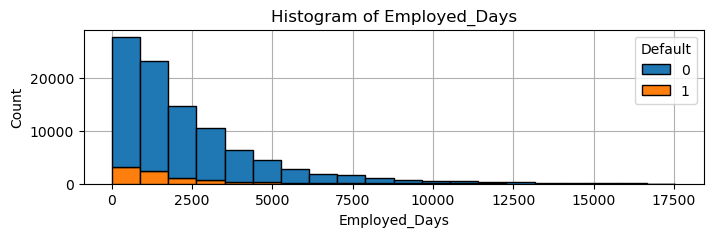

In [10]:
# Client_Income trim이후 다시 확인
vis_num(df3, 'Client_Income', trimIQR=3,
        bins=20, describe=False)
vis_num(df3, 'Employed_Days', trimIQR=10,
        bins=20, describe=False)

,0.0,1.0
count,77724,40551


N-unique : 2


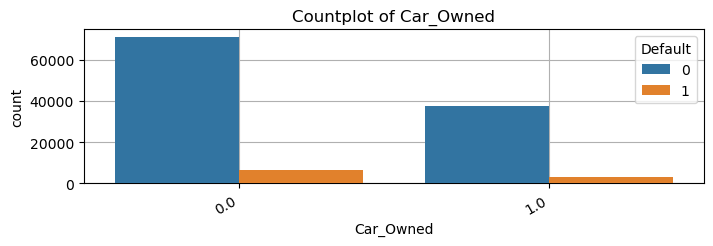

,0.0,1.0
count,78948,39284


N-unique : 2


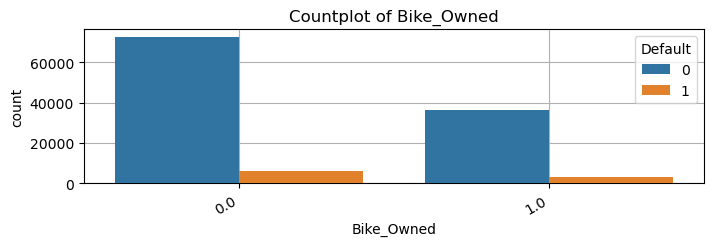

,0.0,1.0
count,59208,59013


N-unique : 2


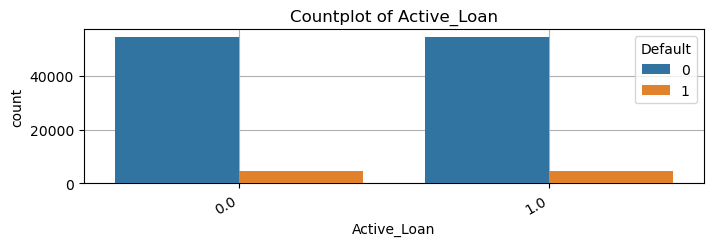

,1.0,0.0
count,81798,36397


N-unique : 2


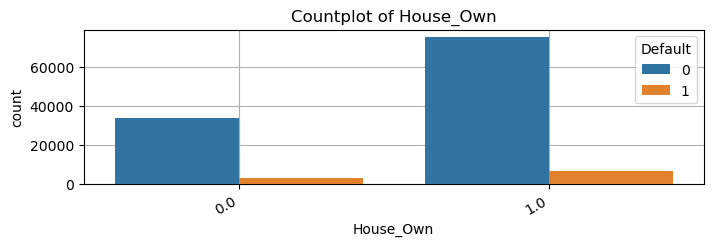

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,14.0,10.0,8.0,9.0,12.0,19.0
count,82834,23431,10294,1430,167,34,12,4,4,3,2,1,1,1


N-unique : 14


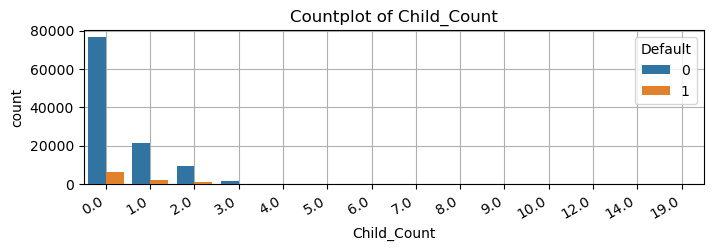

,Service,Commercial,Retired,Govt Job,Student,Unemployed,Maternity leave,Businessman
count,61028,27764,21043,8303,8,6,2,1


N-unique : 8


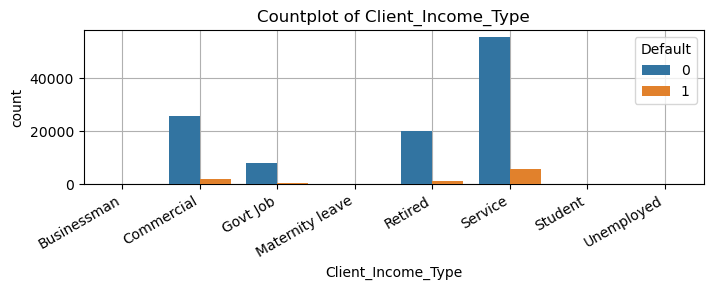

,Secondary,Graduation,Graduation dropout,Junior secondary,Post Grad
count,83911,28819,3960,1455,66


N-unique : 5


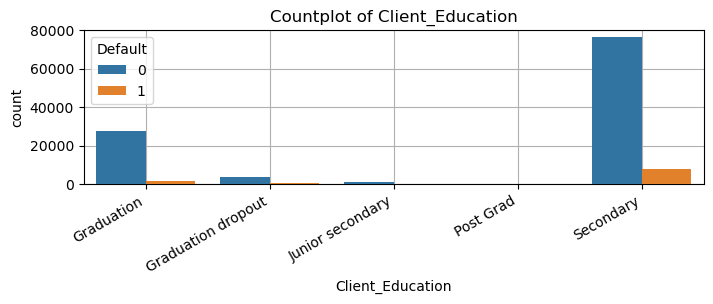

,M,S,D,W
count,87349,17404,7556,6074


N-unique : 4


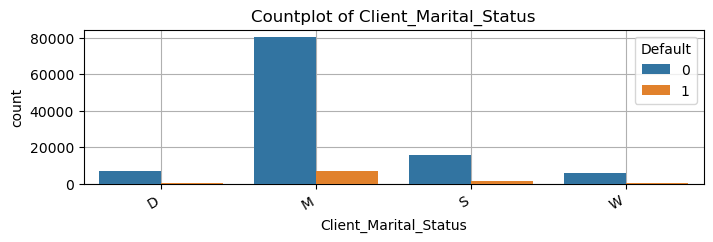

,Male,Female,XNA
count,78463,40977,3


N-unique : 3


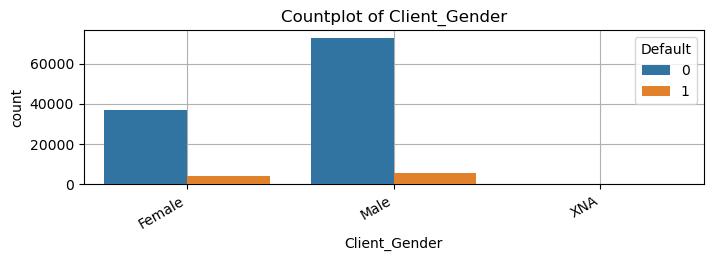

,CL,RL
count,107118,11087


N-unique : 2


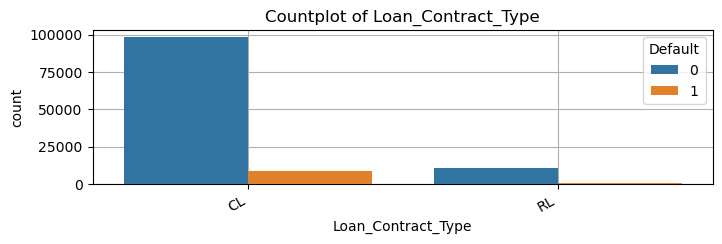

,Home,Family,Municipal,Rental,Office,Shared
count,104870,5783,4248,1816,1002,450


N-unique : 6


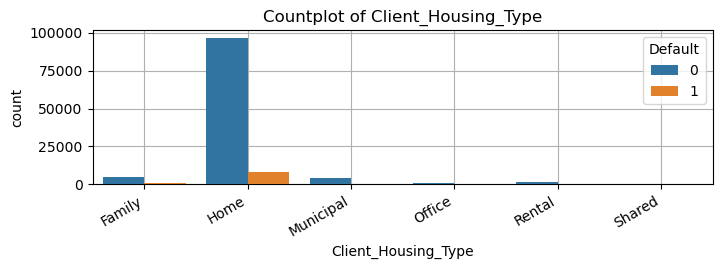

,Laborers,Sales,Core,Managers,Drivers,High skill tech,Accountants,Medicine,Security,Cooking,Cleaning,Private service,Low-skill Laborers,Secretaries,Waiters/barmen,Realty agents,HR,IT
count,21024,12136,10611,8099,7150,4317,3766,3172,2683,2224,1722,1006,787,531,511,280,206,196


N-unique : 18


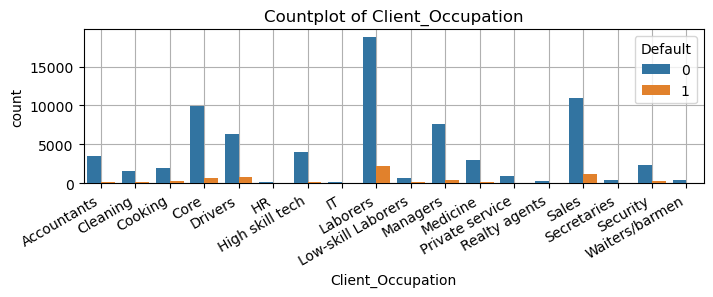

,2.0,1.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,12.0,16.0,13.0,14.0,15.0
count,61652,26213,20434,9583,1349,157,32,11,4,3,3,2,1,1,1


N-unique : 15


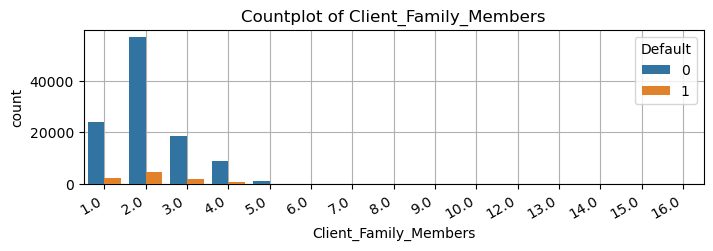

,2.0,3.0,1.0,4.0,5.0,6.0,0.0
count,20907,20116,19712,19668,19613,13125,6287


N-unique : 7


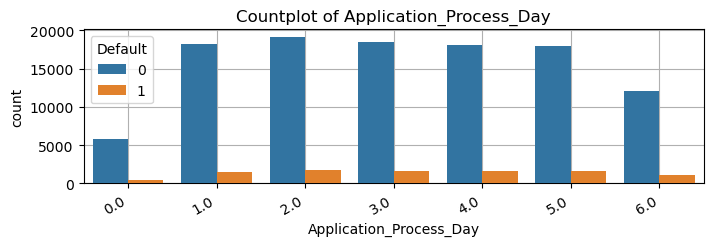

,10.0,11.0,12.0,13.0,14.0,9.0,15.0,16.0,17.0,8.0,...,5.0,4.0,3.0,20.0,21.0,2.0,22.0,1.0,0.0,23.0
count,14465,14413,12977,11765,10702,10525,9614,7739,5843,5821,...,1437,854,506,494,164,112,67,28,26,14


N-unique : 24


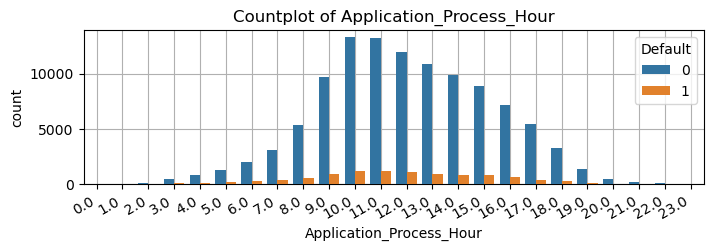

In [11]:
# 범주형 변수 몇개 시각화
def vis_cat(data, col, describe=True):
    if describe == True:
        display(data[col].value_counts().to_frame(name='count').T)
        print(f'N-unique : {data[col].nunique()}')

    plt.figure(figsize=(8,2))
    sns.countplot(data=data, x=col, hue='Default',
                 zorder=3)
    plt.grid(zorder=0)
    plt.xticks(rotation=30, ha='right')
    plt.title(f'Countplot of {col}')
    plt.show()
    

for i in cat_cols:
    if (i != 'Type_Organization') & (i != 'Default'): 
        vis_cat(df3, i)

# 마찬가지로 별다른 특징을 확인하긴 힘들다.
# Gender의 XNA => NaN 으로 변환

* Employed_Days에서 이상치 존재.    
=> NaN 으로 변경
* Client_Income은 매우큰 이상치들이 존재하지만 논리적으로 이상하진 않다.  
=> 필요할때 로그스케일로 변환하거나 trim하여 사용.
* 범주형은 별다른 이상치가 없었다.  

* 시각화 결과 target과 확연한 관계를 보이는 feature는 찾지 못하였다.

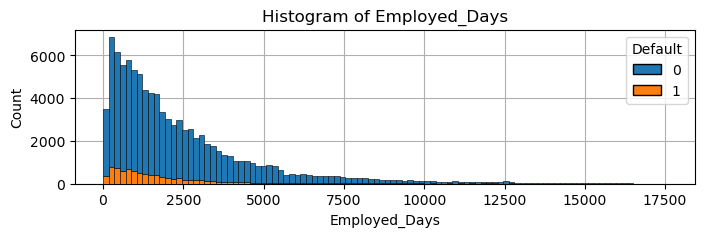

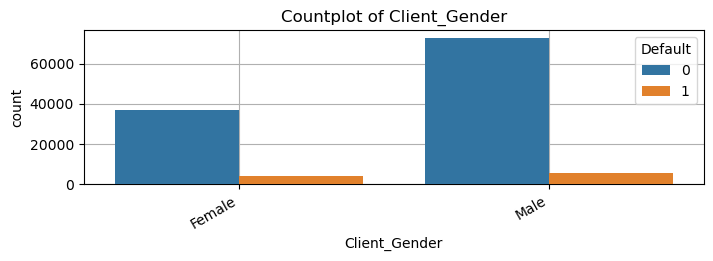

In [12]:
# 이상치 처리
def prepro3(data):
    data = data.copy()
    # 성별이 XNA이면 NaN으로 변환
    data.Client_Gender.replace('XNA', np.nan, inplace=True)
    data.Type_Organization.replace('XNA', np.nan, inplace=True)
    # 고용일수가 60*365(=60년) 이상이면 이상치로 간주하고 결측치로 변환
    idx = data[data.Employed_Days > 60*365].index
    data.loc[idx,'Employed_Days'] = np.nan
    return data

df4 = prepro3(df3)

vis_num(df4, 'Employed_Days', describe=False)
vis_cat(df4, 'Client_Gender', describe=False)
# 이상치 제거됨

## 가설확인 및 검정(EDA 단계)

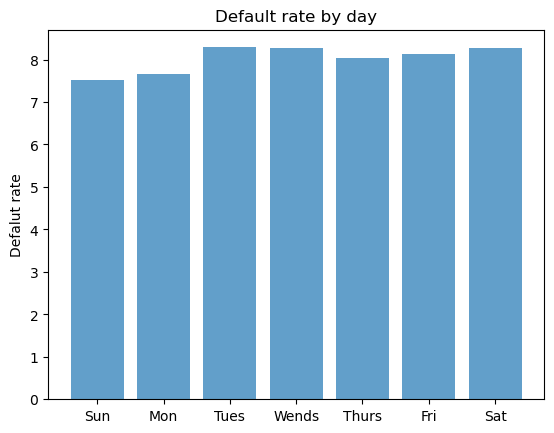

Chi^2 test p-value : 0.101



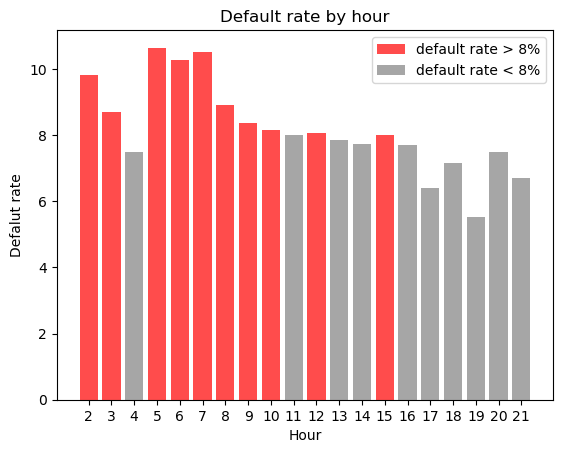

Chi^2 test p-value : 0.0


In [13]:
# EDA 단계에서 설정한 가설은 아래와 같다.
# 1.계약요일 및 시간이 채무불이행율과 관련있을것이다.
# 2.가족 구성원이 많아질수록 채무불이행율은 낮아질 것이다.

## 1번
# 계약요일 및 시간은 범주형 변주이므로 카이제곱 검정을 통해 확인한다.
X = pd.crosstab(index=df4.Default, columns=df4.Application_Process_Day).T
X['ratio'] = 100*X[1]/(X[0]+X[1])

plt.bar(x=X.index, height=X.ratio, alpha=0.7)
plt.xticks(ticks=X.index, labels=X.index.map(feature_dict['Application_Process_Day']))
plt.title('Default rate by day')
plt.ylabel('Defalut rate')
plt.show()
pv1 = chi2_contingency(X.loc[:,[0,1]].T).pvalue
print(f'Chi^2 test p-value : {pv1.round(3)}\n')
# p-value = 0.1 > 0.05 이므로 계약요일은 채무불이행율과 관련이 없다.

# 계약 시간과 채무불이행율의 관계도 알아본다.
X = pd.crosstab(index=df4.Default, columns=df4.Application_Process_Hour).T
# 빈도수 5미만인 시간 삭제
X = X[X[1] > 5]
X['ratio'] = 100*X[1]/(X[0]+X[1])

plt.bar(x=X[X.ratio>8].index, height=X[X.ratio>8].ratio,
       color='red', alpha=0.7, label='default rate > 8%')
plt.bar(x=X[X.ratio<=8].index, height=X[X.ratio<=8].ratio,
       color='grey', alpha=0.7, label='default rate < 8%')
plt.xticks(ticks=X.index)
plt.xlabel('Hour')
plt.ylabel('Defalut rate')
plt.legend()
plt.title('Default rate by hour')
plt.show()
pv2 = chi2_contingency(X.loc[:,[0,1]].T).pvalue
print(f'Chi^2 test p-value : {pv2.round(3)}')
# p-value = 0.0 > 0.05 이므로 계약시간과 채무불이행율은 관련이 있다.
# 계약시간이 새벽~오전인경우 오후~밤보다 채무불이행율이 살짝 높다.

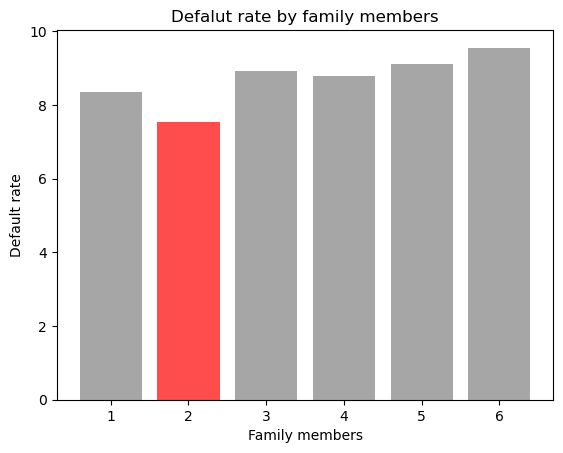

Chi^2 test p-value : 0.224


In [14]:
## 2번
# 가족구성원 숫자와 채무불이행율 확인

X = pd.crosstab(index=df4.Default, columns=df4.Client_Family_Members).T
X = X[X[1]>10]
X['ratio'] = 100*X[1]/(X[0]+X[1])

color = ['grey','red','grey','grey','grey','grey']
plt.bar(x=X.index, height=X.ratio, alpha=0.7,
       color=color)
plt.title('Defalut rate by family members')
plt.xlabel('Family members')
plt.ylabel('Default rate')
plt.show()

# 가족구성원이 2명인경우를 제외하고 카이제곱 검정
pv3 = chi2_contingency(X.loc[[1,3,4,5,6],[0,1]].T).pvalue
print(f'Chi^2 test p-value : {pv3.round(3)}')
# p-value = 0.224 > 0.05 이므로 가족구성원이 2명일때를 제외하곤
# 채무불이행율이 다르다고 할 수 없다. 가족구성원이 2명인경우 유의미하게 낮다.

검정결과는 아래와 같다.  
1. 계약요일과 채무불이행율은 관계가 없다.  
2. 계약시간이 새벽\~오전이면 오후\~밤 보다 채무불이행율이 높다.  
3. 가족구성원은 2명인경우를 제외하면 채무불이행율과 관계가 없다.  
가족구성원이 2명인경우 채무불이행율이 유의미하게 낮다.

## 결측치 처리
* 사용할 Model은 RandomForest와 LightGBM  
=>RandomForest는 결측치 처리가 필요하고 LightGBM은 필요하지 않다.


In [15]:
print('결측율')
print((df4.isna().sum()/df4.shape[0]).sort_values(ascending=False)[:5])
print('\n카디널리티')
print(df4[cat_cols].nunique().sort_values(ascending=False)[:5])
# Client_Occupation과 Employed_Days, Type_Organization를 제외하곤
# 2~3% 정도의 결측치가 존재. 
# Client_Occupation, Type_Organization은 범주형, Employed_Days는 연속형

# => 나머지 feature들은 SimpleImputer 사용(연속:median, 범주:most_frequent)
# => 결측율높은 3개는 다중대치법 사용.

결측율
Client_Occupation     0.340032
Employed_Days         0.203223
Type_Organization     0.202649
Loan_Annuity          0.039604
Client_Income_Type    0.030372
dtype: float64

카디널리티
Type_Organization           57
Application_Process_Hour    24
Client_Occupation           18
Client_Family_Members       15
Child_Count                 14
dtype: int64


In [16]:
# 카디널리티가 높은 T_O와 C_O 타겟인코딩
cols_te = ['Type_Organization', 'Client_Occupation']
# 범주형 feature중 문자열로 되있는것만 오디널인코딩
cols_oe = ['Client_Income_Type', 'Client_Education', 'Client_Marital_Status',\
           'Client_Gender', 'Loan_Contract_Type', 'Client_Housing_Type',\
           'Client_Occupation']

oe = OrdinalEncoder(cols=cols_oe,
                    handle_missing='return_nan')
te = TargetEncoder(cols=cols_te,
                   smoothing=20,
                   handle_missing='return_nan')

def prepro4(data, fit=False):
    data = data.copy()
    X = data.drop(columns=['ID','Default'])
    y = data[target].astype('int')      
    if fit==True:
        X = oe.fit_transform(X)
        X = te.fit_transform(X, y)
    else:
        X = oe.transform(X)
        X = te.transform(X)
    return X, y
    
    
    
def imputer(data, **kwarg):
    data = data.copy()
    num_cols = ['Client_Income', 'Credit_Amount', 'Loan_Annuity',\
                'Age_Days', 'Employed_Days', 'Registration_Days']
    cat_cols = list(data.loc[:, ~data.columns.isin(num_cols)])
    # 3개 feature뺴고 SimpleImpute
    cat_cols.remove('Client_Occupation')
    cat_cols.remove('Type_Organization')
    num_cols.remove('Employed_Days')
    
    sim1 = SimpleImputer(strategy='median').set_output(transform='pandas')
    sim2 = SimpleImputer(strategy='most_frequent').set_output(transform='pandas')
    
    data[num_cols] = sim1.fit_transform(data[num_cols])
    data[cat_cols] = sim2.fit_transform(data[cat_cols])
    
    ct = make_column_transformer((RobustScaler(), num_cols),
                                remainder='passthrough',
                                verbose_feature_names_out=False)
    ct.set_output(transform='pandas')
    data2 = ct.fit_transform(data)
    
    impr = IterativeImputer(initial_strategy='median',
                            random_state=42,
                           **kwarg)
    impr.set_output(transform='pandas')

    data2 = impr.fit_transform(data2)
    data2[num_cols] = data[num_cols]
    
    return data2
    

In [17]:
X, y = prepro4(df4, fit=True)
X_im = imputer(X, verbose=1, max_iter=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                  stratify=y,
                                                  random_state=42)

X_train_im, X_test_im, y_train, y_test = train_test_split(X_im, y, test_size=0.2,
                                                  stratify=y,
                                                  random_state=42)


[IterativeImputer] Completing matrix with shape (121856, 22)
[IterativeImputer] Change: 4655.8814488527605, scaled tolerance: 17.546 
[IterativeImputer] Change: 636.1099748444735, scaled tolerance: 17.546 
[IterativeImputer] Change: 55.288391095732095, scaled tolerance: 17.546 
[IterativeImputer] Change: 5.706164095606483, scaled tolerance: 17.546 
[IterativeImputer] Early stopping criterion reached.


In [18]:
X_train = X_train.astype('float')
X_test = X_test.astype('float')

# 2.모델링
---
* Base모델의 정확도와 f1 스코어 확인
* 전처리가 끝난 데이터를 가지고 RF와 XGB로 모델링
* GridSearch로 간단한 하이퍼파라미터 튜닝
* 모델링 이후 성능평가 및 1변수 PDP와 PI로 가설검정

## 학습 및 검증

In [19]:
import warnings
warnings.filterwarnings(action='ignore')

# Base모델 : 최빈값
base = [y_train.mode()[0]]*len(y_train)

print(classification_report(y_train, base))

# 정확도는 92% 이지만 f1-score는 0이다.
# 클래스 불균형이 심하므로 정확도가 아니라 f1-score로 성능확인

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     89608
           1       0.00      0.00      0.00      7876

    accuracy                           0.92     97484
   macro avg       0.46      0.50      0.48     97484
weighted avg       0.84      0.92      0.88     97484



In [20]:
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=10,
                            max_features='log2',
                            class_weight='balanced',
                            n_jobs=-1,
                            random_state=42)

xgb = XGBClassifier(n_estimators=200,
                    booster='gbtree',
                    learning_rate=0.1,
                    eval_metric='aucpr',
                    early_stopping_rounds=15,
                    scale_pos_weight=11.5,
                    gpu_id=0,
                    tree_method='gpu_hist',
                    predictor='gpu_predictor',
                    n_jobs=-1,
                    random_state=42)

rf_params = {'max_depth':[8,9,10,11,12],
             'max_features':['sqrt','log2'],
             'class_weight':[{1:x, 0:1-x} for x in np.linspace(0.7, 0.98, 5)]}

xgb_params = {'max_depth':[8,9,10,11,12],
              'colsample_bytree':[0.5, 0.8],
              'reg_alpha':[1, 5, 10, 20],
              'scale_pos_weight':[9,10,11.5,13]}

rf_grid = GridSearchCV(estimator=rf,
                       param_grid=rf_params,
                       scoring='f1',
                       error_score='raise',
                       verbose=2,
                       cv=2)

xgb_grid = GridSearchCV(estimator=xgb,
                        param_grid=xgb_params,
                        scoring='f1',
                        cv=2,
                        error_score='raise',
                        verbose=2)

In [21]:
# rf_grid.fit(X_train_im, y_train)
# joblib.dump(rf_grid.best_estimator_, 'rf_model.pkl')

In [22]:
# xgb_grid.fit(X_train, y_train)
# joblib.dump(xgb_grid.best_estimator_, 'xgb_model.pkl')

In [23]:
xgb_best = joblib.load('xgb_model.pkl')
rf_best = joblib.load('rf_model.pkl')

rf_score1 = f1_score(y_train, rf_best.predict(X_train_im))
rf_score2 = f1_score(y_test, rf_best.predict(X_test_im))

xgb_score1 = f1_score(y_train, xgb_best.predict(X_train))
xgb_score2 = f1_score(y_test, xgb_best.predict(X_test))

print('RandomForest')
print(f"train f1 : {rf_score1.round(3)}")
print(f"test f1 : {rf_score2.round(3)}")
print(classification_report(y_test, rf_best.predict(X_test_im)))

print('\nXGBoost')
print(f"train f1 : {xgb_score1.round(3)}")
print(f"test f1 : {xgb_score2.round(3)}")
print(classification_report(y_test, xgb_best.predict(X_test)))

# XGBoost와 RandomForest의 성능이 비슷한모습이다.
# 둘모두 accuracy = 0.8 정도로 기준모델의 0.92보단 내려갔지만,
# 1의 f1 스코어가 0.25정도로 더 높아졌다.

RandomForest
train f1 : 0.361
test f1 : 0.234
              precision    recall  f1-score   support

           0       0.94      0.82      0.88     22403
           1       0.17      0.40      0.23      1969

    accuracy                           0.79     24372
   macro avg       0.55      0.61      0.56     24372
weighted avg       0.88      0.79      0.83     24372


XGBoost
train f1 : 0.564
test f1 : 0.252
              precision    recall  f1-score   support

           0       0.94      0.84      0.89     22403
           1       0.18      0.41      0.25      1969

    accuracy                           0.80     24372
   macro avg       0.56      0.62      0.57     24372
weighted avg       0.88      0.80      0.83     24372



검증결과
* XGBoost와 RandomForest의 성능이 비슷한모습이다.
* 둘모두 accuracy = 0.8 정도로 기준모델의 0.92보단 내려갔지만,
* 1(채무불이행) 의 f1 스코어가 0.25정도로 더 높아졌다.  
=>일반화 성능을위해 훈련과 검증의 점수차이가 크지않은 랜덤포레스트 채택

## 기대이득

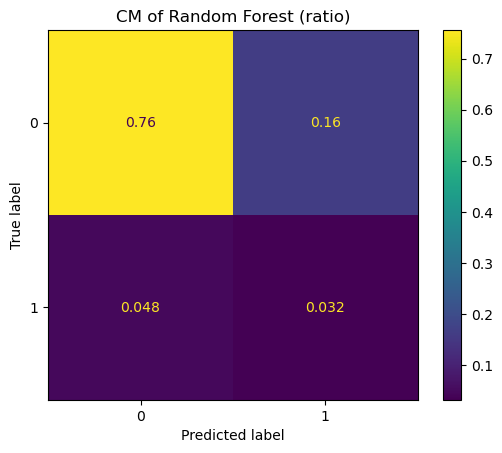

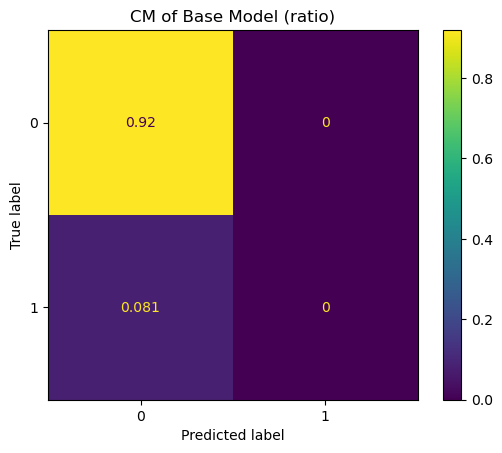

In [24]:
# FP = 정상인데 채무불이행으로 예측 => 기회비용(이익감소)
# FN = 채무불이행인데 정상으로 예측 => 손해발생
# TP = 채무불이행을 제대로 예측하여 반려 => 아무일 없음
# TN = 정상을 정상으로 예측 => 수익창출

# 정상 고객 1명당 수익기대값이 a, 채무불이행 고객 1명당 손실 기대값이 b라고 할때,
# 수익은 TN*a -FP*a - FN*b
pred = rf_best.predict(X_test_im)


cm = confusion_matrix(y_test, pred, labels=rf_best.classes_)
cm = cm / cm.sum()
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_best.classes_)
disp.plot()
plt.title('CM of Random Forest (ratio)')
plt.show()

cm2 = confusion_matrix(y_test, [0]*y_test.shape[0], labels=rf_best.classes_)
cm2 = cm2 / cm2.sum()
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,
                              display_labels=rf_best.classes_)
disp2.plot()
plt.title('CM of Base Model (ratio)')
plt.show()

# 0.76a - 0.16a - 0.048b = rf 기대수익
# 0.92a - 0.081b = base 기대수익
# rf > base 일 조건 => b >= 9.7a


* 손실기대값 b가 수익기대값 a보다 9.7배이상 크면   
모델을 활용할 가치가 있다.

## 모델해석

In [25]:
# 몇가지 feature에 대하여 모델해석을 진행
# 먼저, 가설1(연령은 예측에 중요한 영향을 미치는 요소중 하나)을 검정하기위헤
# Permutation Importance 계산
from sklearn.inspection import permutation_importance

pi = permutation_importance(rf_best, X_test_im, y_test,
                            n_repeats=10,
                            n_jobs=-1,
                            scoring='f1',
                            random_state=42)

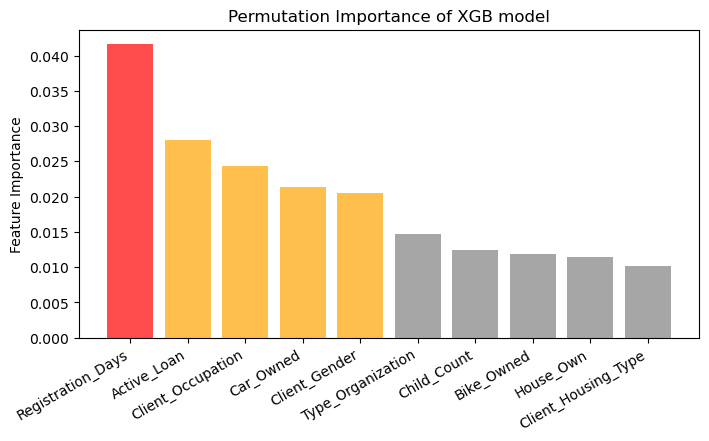

In [26]:
pi_result = pd.Series(pi.importances_mean, index=X_test.columns, name='Importace')
pi_result = pi_result.sort_values(ascending=False)

plt.figure(figsize=(8,4))
color = ['red']*1 + ['orange']*4 + ['grey']*5
plt.bar(x=pi_result[:10].index, height=pi_result[:10],
       color=color, alpha=0.7)
plt.ylabel('Feature Importance')
plt.title('Permutation Importance of XGB model')
plt.xticks(rotation=30, ha='right')
plt.show()

# 상위10개중 중요한 4개 순서
# Registration_Days > Active_Loan > Client_Occupation > Car_Owned
# 가설1은 기각.

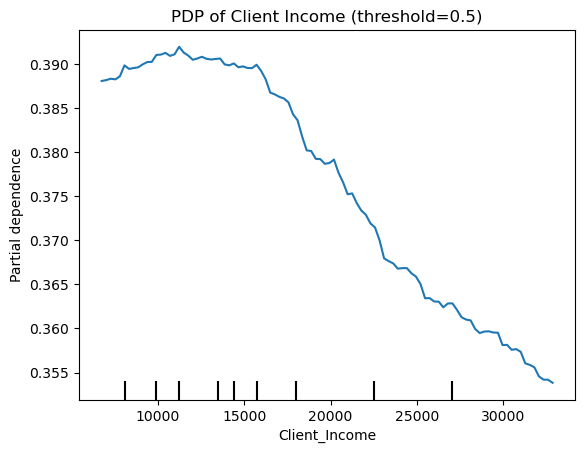

In [27]:
# 가설2(Client_Income이 오르면 채무불이행율 예측값은 감소) 를 검증하기위해
# 1특성 PDP 계산
from sklearn.inspection import PartialDependenceDisplay

pdp = PartialDependenceDisplay.from_estimator(rf_best, X_train_im,
                                        ['Client_Income'])
plt.title('PDP of Client Income (threshold=0.5)')
plt.show()
# 약 12000$ 까지는 수입이 오르면 채무불이행 예측값이 소폭 증가
# 12000$~30000$ 까지 수입이 오르면 채무불이행 예측값이 감소

# => 12000$ ~ 30000$ 사이의 소득을 가진 계층을 긍정적으로 판단 가능
# 단, 모든 범위에 대하여 채무불이행 확률은 0.5 아래임을 인지해야함.

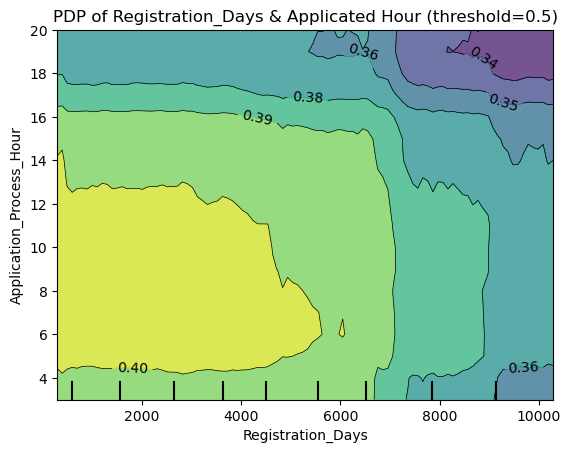

In [28]:
# 상위 4개중 Credit Amount와 Employed Days의 PDP 확인
pdp2 = PartialDependenceDisplay.from_estimator(rf_best, X_train_im.sample(300, random_state=42),
                                               features=[('Registration_Days','Application_Process_Hour')])
plt.title('PDP of Registration_Days & Applicated Hour (threshold=0.5)')
plt.show()

# 보라 => 노랑 으로 갈수록 채무불이행 예측값이 높아진다.
# 차량등록기간이 짧을수록, 시간이 새벽4시~정오 일때 채무불이행율을 높게 예측한다.

* 가설1은 기각됨. 연령이 예측값에 중요한 영향을 미치지 않는다.
* 가설2는 12000$ 이상의 범위에서 성립.
* 모델에서 중요한 feature : Registration_Days > Active_Loan > Client_Occupation > Car_Owned

## 모델 한계점 및 개선방향

* 기본적으로 f1값이 비교적 낮다.
* 랜덤포레스트 모델은 인코딩과 결측값의 영향을 받는다.  
=> 인코딩방법과 결측치 대치법 개선필요

* 클래스 불균형을 문제를 해결해야한다. 본 모델은 클래스가중치만 적용.  
=> 다양한 샘플링기법 활용고려. 혹은 이상치탐지가 목적인 다른 알고리즘 적용고려.

* 전처리중 기준에따라 드랍한 feature들 존재.  
=> 기준완화 혹은 별도 데이터 추가로 도입 고려.

In [29]:
# 모델한계 범위 표기
num_cols = ['Client_Income', 'Credit_Amount', 'Loan_Annuity',\
                'Age_Days', 'Employed_Days', 'Registration_Days']

model_range = pd.DataFrame({'Min':X[num_cols].min(),
                            'Max':X[num_cols].max()})

model_range

,Min,Max
Client_Income,2565.00,1800009.0
Credit_Amount,4500.00,405000.0
Loan_Annuity,217.35,22500.0
Age_Days,7676.00,25201.0
Employed_Days,0.00,17546.0
Registration_Days,0.00,23738.0
